# <center>Analyzing Employee Preferences in Companies</center>
## <center>Spring 2024 Data Science Project</center>

**Member 1: Karthik Taranath**, Contribution: 100%

**Member 2: Jadon Trackim**, Contribution: 100%

"We, all team members, agree together that the above information is true, and we are confident about our contributions to this submitted project/final tutorial."

*Karthik Taranath*: May 7, 2024

*Jadon Trackim*: May 7, 2024

## <center>Introduction</center>

The world of business is incredibly complicated and often inexplicable. While business theory can offer some explanation as to why some companies thrive while others fail, the real world is often more complex than textbook scenarios and its results may not be truly unpredictable. This is where data science can come into play to help bolster our understanding.

Machine learning allows us to make predictions based on many different inputs in a way that was not feasible before its advent. This provides us with a unique ability to examine many key attributes of over 7,000 companies. We used a [dataset](https://www.kaggle.com/datasets/vedantkhapekar/top-10000-companies-dataset) on Kaggle from Ambition Box, a website where current and past employees can give feedback on the companies they have worked at. Through this data extraction process, we were able to use machine learning, specifically a neural network and a linear regression model, to analyze these attributes to predict the success of a company in terms of how their employees rate their respective companies. We aim to determine which aspects of a company have the biggest impact on the rating that its employees give it. The aspects of a company that we will be examining are skill development/learning, work-life balance, salary and benefits, company culture, work satisfaction, average salary, job security, and promotions/appraisal.


In [249]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

## <center>Data Curation</center>

In [267]:
df = pd.read_csv('content/companies.csv')

def str_to_num(string):
  if string == '--':
    return np.nan
  ret = string
  if string[-1] == 'k':
    ret = float(string[:-1]) * 1000

  return int(ret)

# parse number strings
for col in ['Total_reviews', 'Avg_salary', 'Interviews_taken', 'Total_jobs_available', 'Total_benefits']:
  df[col] = df[col].apply(str_to_num)

# remove rows where there are invalid values
for col in df.columns:
  nans = len(df[pd.isna(df[col])])
  # only if there are less than 250 nan values because we don't want to remove too much data
  if nans < 250:
    print('Removing', end=' ')
    df = df[~pd.isna(df[col])]
  else:
    print('Keeping ', end=' ')
    
  print(f'{nans:>4d} NaNs in {col}')

# turn descriptors into lists
df.loc[:, 'Description'] = df['Description'].apply(lambda x: x.split(' | ') if type(x) == str else np.nan)
df.loc[:, 'Highly_rated_for'] = df['Highly_rated_for'].apply(lambda x: x.split(', ') if type(x) == str else np.nan)
df.loc[:, 'Critically_rated_for'] = df['Critically_rated_for'].apply(lambda x: x.split(', ') if type(x) == str else np.nan)

#convert rupees to dollars
df.loc[:, 'Avg_salary'] *= 0.012


def rating(cat, row):
  # if either is an invalid entry (e.g. NaN), then set the value to 0
  if type(row['Highly_rated_for']) == float or type(row['Critically_rated_for']) == float:
    return 0
  
  # if the company is critically rated for the category, assign it a -1
  elif cat in row['Critically_rated_for']:
    return -1

  # if the company is highly rated for the category, assign it a 1
  elif cat in row['Highly_rated_for']:
    return 1
  else:
    return 0

# create columns for each feature
features_df = df.loc[:, ['Company_name', 'Ratings', 'Avg_salary']]
for cat in df['Highly_rated_for'].explode().unique():
  features_df.loc[:, cat] = df.apply(lambda row: rating(cat, row), axis=1)

display(df)
display(features_df)

Removing    0 NaNs in Company_name
Removing    0 NaNs in Description
Removing    0 NaNs in Ratings
Removing   92 NaNs in Highly_rated_for
Keeping  7101 NaNs in Critically_rated_for
Removing    0 NaNs in Total_reviews
Removing    2 NaNs in Avg_salary
Removing  213 NaNs in Interviews_taken
Keeping  3728 NaNs in Total_jobs_available
Removing   73 NaNs in Total_benefits


,Company_name,Description,Ratings,Highly_rated_for,Critically_rated_for,Total_reviews,Avg_salary,Interviews_taken,Total_jobs_available,Total_benefits
0,TCS,"[IT Services & Consulting, 1 Lakh+ Employees, ...",3.8,"[Job Security, Work Life Balance]","[Promotions / Appraisal, Salary & Benefits]",73100,10282.800,6100.0,847.0,11500.0
1,Accenture,"[IT Services & Consulting, 1 Lakh+ Employees, ...",4.0,"[Company Culture, Skill Development / Learning...",NaN,46400,7015.200,4300.0,9900.0,7100.0
2,Cognizant,"[IT Services & Consulting, 1 Lakh+ Employees, ...",3.9,[Skill Development / Learning],[Promotions / Appraisal],41700,6738.000,3600.0,460.0,5800.0
3,Wipro,"[IT Services & Consulting, 1 Lakh+ Employees, ...",3.8,[Job Security],"[Promotions / Appraisal, Salary & Benefits]",39200,5128.800,3700.0,405.0,5000.0
4,Capgemini,"[IT Services & Consulting, 1 Lakh+ Employees, ...",3.9,"[Job Security, Work Life Balance, Skill Develo...","[Promotions / Appraisal, Salary & Benefits]",34000,4972.800,2800.0,719.0,4000.0
...,...,...,...,...,...,...,...,...,...,...
9995,Techila Global Services,"[IT Services & Consulting, 501-1k Employees, 1...",3.7,"[Work Life Balance, Salary & Benefits, Company...",NaN,72,5.448,2.0,26.0,21.0
9996,RxLogix Corporation,"[Pharma, 201-500 Employees, 14 years old, Prin...",2.6,"[Work Life Balance, Work Satisfaction, Company...",NaN,72,9.588,15.0,9.0,13.0
9997,Avians Innovations Technology,"[Building Material, 51-200 Employees, 17 years...",3.7,"[Promotions / Appraisal, Work Satisfaction, Sa...",NaN,72,5.868,3.0,11.0,8.0
9998,ACPL Systems,"[Law Enforcement & Security, 51-200 Employees,...",3.3,"[Promotions / Appraisal, Salary & Benefits, Wo...",NaN,72,6.240,4.0,1.0,10.0


,Company_name,Ratings,Avg_salary,Job Security,Work Life Balance,Company Culture,Skill Development / Learning,Promotions / Appraisal,Salary & Benefits,Work Satisfaction
0,TCS,3.8,10282.800,1,1,0,0,-1,-1,0
1,Accenture,4.0,7015.200,0,0,0,0,0,0,0
2,Cognizant,3.9,6738.000,0,0,0,1,-1,0,0
3,Wipro,3.8,5128.800,1,0,0,0,-1,-1,0
4,Capgemini,3.9,4972.800,1,1,0,1,-1,-1,0
...,...,...,...,...,...,...,...,...,...,...
9995,Techila Global Services,3.7,5.448,0,0,0,0,0,0,0
9996,RxLogix Corporation,2.6,9.588,0,0,0,0,0,0,0
9997,Avians Innovations Technology,3.7,5.868,0,0,0,0,0,0,0
9998,ACPL Systems,3.3,6.240,0,0,0,0,0,0,0


## <center>Exploratory Data Analysis</center>

## Statistical Method 1
The first observation is about the distribution of the average ratings of companies. If the ratings are normally distributed, then they can be reliably used in various comparison test that require a normally distributed population.

Mean: 3.8914
Median: 3.9
Standard Deviation: 0.3837


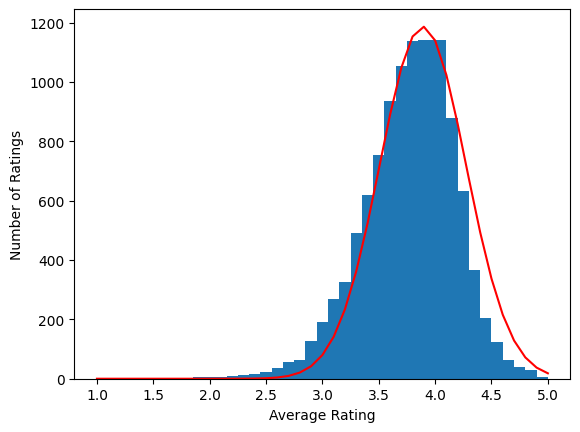

In [268]:
data1 = df.groupby('Ratings')['Company_name'].count()

# calculate mean, median, and standard deviation
mean1 = df['Ratings'].mean()
median1 = df['Ratings'].median()
std1 = df['Ratings'].std()

print(f'Mean: {mean1:.4f}')
print(f'Median: {median1}')
print(f'Standard Deviation: {std1:.4f}')

# plot curve with normal distribution curve over it
ratings = np.arange(1, 5.1, 0.1)
plt.bar(list(data1.keys()), data1.values, width=-0.25, align='edge')
plt.plot(ratings, stats.norm.pdf(ratings, mean1, std1) * data1.max(), c ='r') 
plt.xlabel('Average Rating')
plt.ylabel('Number of Ratings')
plt.show()

This is a unimodal distribution. It looks to be approximately normal, with a slight skew to the left. The average rating is about 3.8914. Meanwhile, the median is 3.9, which means there is very little skew in the data, and that there isn't likely to be many outliers because it is close to the mean. The standard deviation is 0.3837, meaning that the spread is fairly small, as we see the distribution is fairly tight.

## Statistical Method 2
This observation examines the correlation between rating and average salary of the company. If the rating and average salary are positively correlated, then this could show that customers enjoy companies that pay better.

H0: There is no correlation between rating and average salary.

HA: There is a correlation between rating and average salary.

Level of significance (α): 0.05

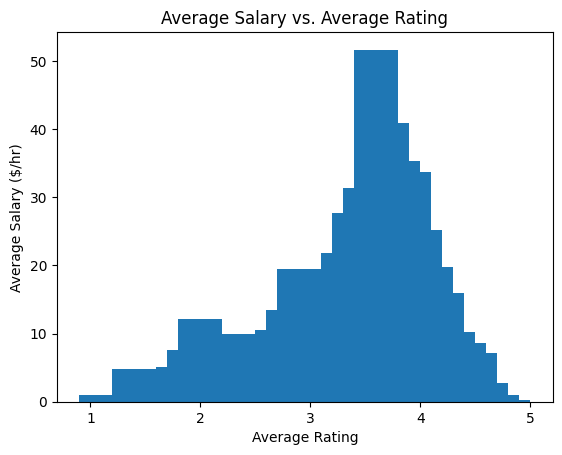

p-value: 2.0897606456713427e-41


In [291]:
# create contingency table for the ratings and average salary features using the scipy library
# scipy documentation can be found at: https://docs.scipy.org/doc/scipy/index.html 
table = stats.contingency.crosstab(np.sort(df['Ratings'].unique()), df.groupby(['Ratings'])['Avg_salary'].mean())

categories = []
for key in list(df.groupby(['Ratings'])['Avg_salary'].groups.keys()):
  categories.append(list(df.groupby(['Ratings'])['Avg_salary'].groups[key]))

# plot average salary against average ratings
plt.bar(np.sort(df['Ratings'].unique()), df.groupby(['Ratings'])['Avg_salary'].mean(), width=-0.4, align='edge')
plt.title('Average Salary vs. Average Rating')
plt.xlabel('Average Rating')
plt.ylabel('Average Salary ($/hr)')
plt.show()

# perform one-way ANOVA test on the data using the scipy stats library
print(f'p-value: {stats.f_oneway(*categories).pvalue}')

Since our p-value is lower than our level of significance, we can reject the null hypothesis and state that average salary does have a correlation with average rating.

## Statistical Method 3
Our third observation is about the correlation between the hiring ratio, which is the ratio of the number of people being interviewed to the number of jobs available and average salary. If the salary increases as the hiring ratio decrease, this would show that as jobs get more competitive, the salary increases.

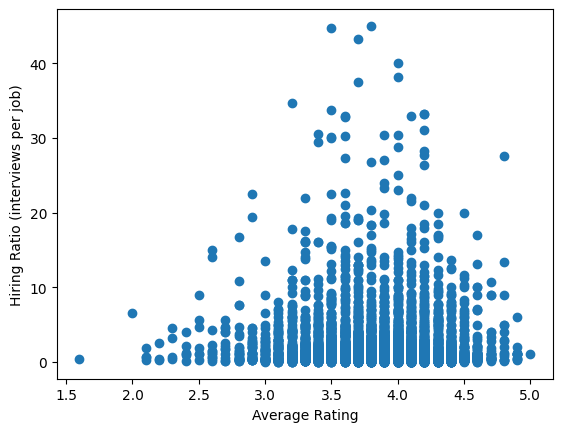

Pearson's correlation coefficient: -0.04866088401930669


In [293]:
# remove NaN values in ratings and columns used to calculate hiring ratio
filtered_df = df[~(np.isnan(df['Total_jobs_available']) | np.isnan(df['Interviews_taken']) | np.isnan(df['Ratings']))].copy()

# create hiring ratio column
filtered_df['Hiring_ratio'] = filtered_df['Total_jobs_available'] / filtered_df['Interviews_taken']

# remove outliers in this hiring ratio column
hiring_std = filtered_df['Hiring_ratio'].std()
hiring_mean = filtered_df['Hiring_ratio'].mean()
filtered_df = filtered_df[np.abs(stats.zscore(filtered_df['Hiring_ratio'])) < 3]

# calculate Pearson's correlation coefficient
pearson = filtered_df['Ratings'].corr(filtered_df['Hiring_ratio'])

# plot points
plt.scatter(filtered_df['Ratings'], filtered_df['Hiring_ratio'])
plt.xlabel('Average Rating')
plt.ylabel('Hiring Ratio (interviews per job)')
plt.show()

print(f'Pearson\'s correlation coefficient: {pearson}')

Because the Pearson correlation coefficient is close to 0, there is no correlation between the hiring ratio and salary.

### Analysis Conclusion
At first, we examined the general shape of our ratings distribution. We discovered that the distribution is unimodal, with the mean being 3.8914. The median is 3.9, which shows there is little skew. The standard deviation is 0.3837, showing that the data is fairly tight with little skew. Additionally, we can tell by this small standard deviation that there are unlikely to be many outliers. The distribution is approximately normal with a slight skew to the left. This tells us a lot about what statistical methods we can use on this data, as many require that we are working with a normally distributed population. One example of this is a t-test.

Our second statistical method was examining a correlation between average salary and the rating of a company. We thought that this could be an easy link to look for in the data. After running a one-way ANOVA test between these two columns, we found a statistically significant correlation between salary and rating. This gives us further insight on the data and one possible relationship within it.

Our final statistical method was examining a link between the hiring ratio and the rating of the company. We thought that as the hiring ratio, that being the percentage of interviewees that went on to be hired by the company, decreased, there would probably be a higher demand for qualified candidates, resulting in a higher rating. We used Pearson’s Correlation Coefficient to examine this relationship and found that there was in fact little to no correlation between these aspects of the data. Thus, our hypothesis was incorrect, and we will not further pursue this avenue of analysis.

Overall, through these statistical methods of analysis, we discovered the general shape of the data and discovered a relationship between salary and rating. We also disproved a potential relationship between hiring ratio and rating. Thus, when building our machine learning model, we chose to include salary and not include hiring ratio, as salary was proven to be related to ratings while hiring ratio was not.

## <center>Primary Analysis</center>

In [272]:
# this neural network is created using the pytorch libraries
# the documentation for this can be found here: https://pytorch.org/docs/stable/index.html

# use gpu if it is available (mps is for ma)
device = torch.device('mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu')

# define neural network class
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.model = nn.Sequential(
            # start with the size being the same amount of inputs
            nn.Linear(input_size, 32),
            nn.ReLU(),
            nn.Dropout(),

            # scale up to discover hidden features
            nn.Linear(32, 128),
            nn.ReLU(),
            nn.Dropout(),

            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(),

            nn.Linear(64, 16),
            nn.ReLU(),
            nn.Dropout(),

            # scale down to output size
            nn.Linear(16, output_size),
        )

    def forward(self, x):
        return self.model(x)

PATH = './model.pth'

In [275]:
# column 0 is company name, column 1 is ratings, so the features are the rest of the columns
features = features_df.columns[2:]
X = features_df[features].to_numpy()
y = np.array([features_df['Ratings']]).T

# split data to prevent bias in testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# scale data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# create tensors that can be passed into the dataloaders
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

# create dataloaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
trainloader = DataLoader(train_dataset, shuffle=True)

In [197]:
model = NeuralNetwork(X.shape[1], y.shape[1])
model.train()
epochs = 15

# use mean squared loss as metric to minimize
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# training loop
size = len(trainloader.dataset)
for epoch in range(epochs):
  print(f'--- Epoch {epoch + 1} ---')
  running_loss = 0.0
  for i, data in enumerate(trainloader):
    inputs, labels = data

    # move data and model to gpu if it's available
    inputs = inputs.to(device)
    labels = labels.to(device)
    model = model.to(device)

    # forward loop and backward propagation
    optimizer.zero_grad()
    outputs = model(inputs)
    loss = loss_fn(outputs, labels)
    loss.backward()
    optimizer.step()

    running_loss += loss.item()
    if i % 1000 == 999:
      print(f'loss: {running_loss / 1000:>4f} [{i+1:>4d}/{size:>4d}]')
      running_loss = 0.0
      
print('Finished training!')    

--- Epoch 1 ---
loss: 4.846122 [1000/7696]
loss: 2.177660 [2000/7696]
loss: 1.744562 [3000/7696]
loss: 1.229083 [4000/7696]
loss: 0.885037 [5000/7696]
loss: 0.680028 [6000/7696]
loss: 0.566956 [7000/7696]
--- Epoch 2 ---
loss: 0.378580 [1000/7696]
loss: 0.312208 [2000/7696]
loss: 0.266417 [3000/7696]
loss: 0.219887 [4000/7696]
loss: 0.196290 [5000/7696]
loss: 0.169969 [6000/7696]
loss: 0.169056 [7000/7696]
--- Epoch 3 ---
loss: 0.157143 [1000/7696]
loss: 0.142303 [2000/7696]
loss: 0.158771 [3000/7696]
loss: 0.149220 [4000/7696]
loss: 0.151943 [5000/7696]
loss: 0.144218 [6000/7696]
loss: 0.149843 [7000/7696]
--- Epoch 4 ---
loss: 0.148248 [1000/7696]
loss: 0.141350 [2000/7696]
loss: 0.142173 [3000/7696]
loss: 0.131110 [4000/7696]
loss: 0.161417 [5000/7696]
loss: 0.148570 [6000/7696]
loss: 0.141076 [7000/7696]
--- Epoch 5 ---
loss: 0.134685 [1000/7696]
loss: 0.140819 [2000/7696]
loss: 0.148884 [3000/7696]
loss: 0.151903 [4000/7696]
loss: 0.161043 [5000/7696]
loss: 0.147405 [6000/7696]
lo

In [283]:
# remove gradient to evaluate
model.eval()
with torch.no_grad():
  y_pred1 = model(X_test_tensor)

  # calculate mean squared error
  error1 = mean_squared_error(y_test_tensor, y_pred1)

print(f'Neural network mean squared error: {error1:.5f}')

Neural network mean squared error: 0.14697


In [294]:
# this linear regression model is created using the scikit learn libraries
# the documentation for this can be found here: https://scikit-learn.org/stable/index.html

# create linear regression model
reg = LinearRegression()

# fit model to training data
reg.fit(X_train_tensor, y_train_tensor)

# predict using test data
y_pred2 = reg.predict(X_test_tensor)

# calculate mean squared error
error2 = mean_squared_error(y_test_tensor, y_pred2)

print(f'Linear regression mean squared error: {error2:.5f}')

Linear regression mean squared error: 0.14427


## <center>Visualization</center>

In [284]:
def plot_error(test, pred, percentage):
  # calculate specific percentage of the range away from the line
  error = (max(test) - min(test)) * percentage / 100
  mask = abs(test - pred) < error

  # split points based on the percentage
  green = plt.scatter(test[mask], pred[mask], c='g')
  red = plt.scatter(test[~mask], pred[~mask], c='r')

  # create legend
  plt.legend((green, red), (f'Points Inside {percentage}% Range', f'Points Outside {percentage}% Range'))

  # plot line to represent a perfect correlations
  plt.plot([1, 5], [1, 5], c='b')
  plt.xlim(1, 5)
  plt.ylim(1, 5)
  plt.title('Predicted Rating vs. Actual Rating')
  plt.xlabel('Actual Rating')
  plt.ylabel('Predicted Rating')
  plt.show()

  # calculate amount of points inside and outside of the range
  correct = len(pred[mask])
  incorrect = len(pred[~mask])
  return correct, incorrect

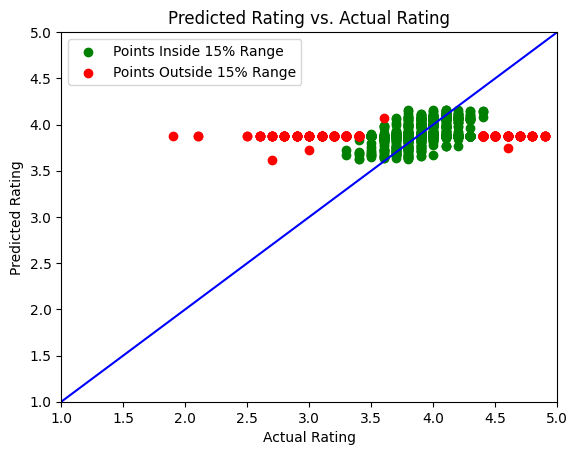

correct (within 15%): 1537
incorrect: 387
inside 15% range: 79.886%



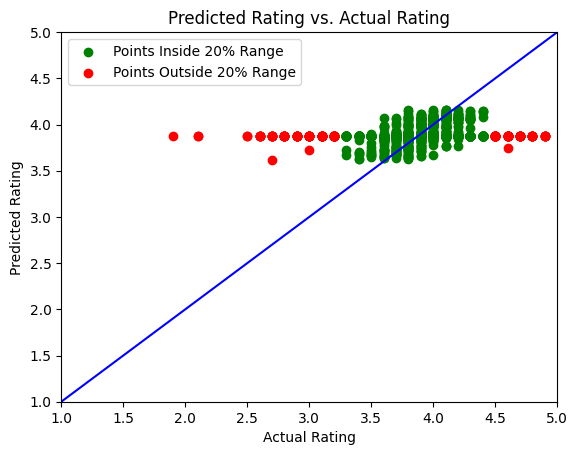

correct (within 20%): 1713
incorrect: 211
inside 20% range: 89.033%



In [288]:
# call function and return results for 15% and 20% ranges
for percentage in [15, 20]:
  correct, incorrect = plot_error(y_test_tensor, y_pred2, percentage)

  print(f'correct (within {percentage}%): {correct}')
  print(f'incorrect: {incorrect}')

  # calculate accuracy metric
  print(f'inside {percentage}% range: {correct / (correct + incorrect) * 100:.3f}%')
  print()

In [290]:
# sort the features from least to most impactful
sorted_weights = sorted(list(zip(reg.coef_[0], features)))
print(f'From least to greatest effect on the model: {[feature for _, feature in sorted_weights]}')
print(f'"{features[np.argmax(reg.coef_)]}" affects the model the most')
print(f'"{features[np.argmin(reg.coef_)]}" affects the model the least')

From least to greatest effect on the model: ['Avg_salary', 'Promotions / Appraisal', 'Job Security', 'Salary & Benefits', 'Company Culture', 'Work Satisfaction', 'Skill Development / Learning', 'Work Life Balance']
"Work Life Balance" affects the model the most
"Avg_salary" affects the model the least


The graph above shows data plotted as points where the x axis is the actual rating and the y axis is the predicted rating by the linear regression model. The line indicates the location of the dots if the linear regression model was perfect, or if the predicted rating was always the same as the actual rating.

We also added color coding to the graph. The green points are the predicted data points within &plusmn;15% of the actual ratings. About 79.886% of the data points were within 10% of our actual ratings, showing that we can fairly accurately predict the rating of a company based on the salary and the highly/critically rated attributes of the company. When we expand our definition a little, we see that 89.033% of our predicted ratings fell within &plusmn;20% of the actual rating. Overall, we can see that there is a very clear relationship between the salary and highly/critically rated attributes of a company and the rating that that company has.

## <center>Insights and Conclusions</center>
### General Insights

We attempted to use both a neural network and a linear regression model to get the most accurate machine learning analysis. 

The neural network had a mean squared error of 0.14381, which is indicative of a very strong neural network. It had a final loss of 0.1427.

The linear regression model had a mean squared error of 0.14000, which once again is indicative of a strong model. The linear regression model also allowed us to see the weights, and thus the importance of the different features we were investigating. The feature that impacted the rating the most was work-life balance and the feature that impacted the rating the least was average salary. The features that were examined, listed from least impactful to most, are average salary, promotions/appraisal, job security, salary and benefits, company culture, work satisfaction, skill development/learning, and work-life balance.


### Conclusions

Ultimately, throughout our procedures, a lot of insight can be gained for informed and uninformed readers alike. For those new the realm of business performance, we explained the categories and methodology in simple terms. Meanwhile, those who have somewhat of a background in business, specifically the theory, have gained insight into a large-scale analysis of actual data about real companies.

There seems to be a common theme among the more impactful features of a company: they are the more social/personal aspects of work, rather than the more tangible/monetary aspects. While promotions, salaries, and job security have the least impact on the performance of a company, skill development/learning, and work-life balance were among the most impactful on a company's rating. 

Finally, we reflect on what this means for companies. The ratings for the companies in this analysis were from current/former employees of those companies. By examining the features that had the biggest impact on the rating, we gain crucial insight into what employees value the most. Employees seem to value personal development, fulfillment, and work-life balance more than high salaries and promotions. This also provides crucial insight to employers looking to improve company morale without increasing expenditure, which as we can see is the most impactful way to improve their employees' view of the company.
